In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import matplotlib.cm as cm

import scipy.signal as signal

from numba import jit

random_state = 0 # Magic

# Renaming columns, joining
Join by frame number

In [2]:
df_fish0 = pd.read_csv('../../data/raw/zebrafish26.01.2017_fish0.csv')
df_fish1 = pd.read_csv('../../data/raw/zebrafish26.01.2017_fish1.csv')

In [3]:
df_fish0.columns

Index(['frame', 'ACCELERATION#pcentroid (cm/s2)', 'ANGLE', 'AX', 'AY',
       'BORDER_DISTANCE#pcentroid (cm)', 'NEIGHBOR_DISTANCE (cm)',
       'SPEED#pcentroid (cm/s)', 'VX (cm/s)', 'VY (cm/s)', 'X (cm)', 'Y (cm)',
       'time#centroid'],
      dtype='object')

In [4]:
cols = ['frame', 'acceleration', 'angle', 'aX', 'aY',
       'border_distance', 'neighbor_distance',
       'speed', 'vX', 'vY', 'x', 'y',
       'time']
df_fish0.columns = cols
df_fish1.columns = cols

In [5]:
df_total = df_fish0.set_index('frame').join(df_fish1, lsuffix='_f0', rsuffix='_f1' )

In [6]:
df_total.columns

Index(['acceleration_f0', 'angle_f0', 'aX_f0', 'aY_f0', 'border_distance_f0',
       'neighbor_distance_f0', 'speed_f0', 'vX_f0', 'vY_f0', 'x_f0', 'y_f0',
       'time_f0', 'frame', 'acceleration_f1', 'angle_f1', 'aX_f1', 'aY_f1',
       'border_distance_f1', 'neighbor_distance_f1', 'speed_f1', 'vX_f1',
       'vY_f1', 'x_f1', 'y_f1', 'time_f1'],
      dtype='object')

## Dedup columns
Right now we Ignore inf values, this should be changed!

Some columns are duplicate, e.g. time, neighbour distance

In [7]:
df_total.drop(['time_f1', 'neighbor_distance_f1'], axis=1, inplace=True)
df_total.rename(columns={'time_f0': 'time', 'neighbor_distance_f0': 'neighbor_distance'}, inplace=True)
df_total = df_total.replace([np.inf, -np.inf], np.nan).dropna()
df_total.index = range(0, len(df_total['time']))
df = df_total

In [8]:
df.describe()

,acceleration_f0,angle_f0,aX_f0,aY_f0,border_distance_f0,neighbor_distance,speed_f0,vX_f0,vY_f0,x_f0,...,acceleration_f1,angle_f1,aX_f1,aY_f1,border_distance_f1,speed_f1,vX_f1,vY_f1,x_f1,y_f1
count,958966.000000,958966.000000,958966.000000,958966.000000,958966.000000,958966.000000,958966.000000,958966.000000,958966.000000,958966.000000,...,958966.000000,958966.000000,958966.000000,958966.000000,958966.000000,958966.000000,958966.000000,958966.000000,958966.000000,958966.000000
mean,19.707095,0.026415,13.131483,12.994123,19.707098,8.946072,1.943691,0.000089,-0.000441,13.131483,...,21.749133,0.085185,14.395056,14.207710,21.749138,2.816721,-0.001979,-0.002315,14.395056,14.207710
std,6.540574,1.903960,6.798111,6.582415,6.540584,6.831658,1.859761,2.253892,2.267216,6.798123,...,7.518722,1.880628,7.697266,7.838720,7.518736,2.557842,2.773980,2.854870,7.697282,7.838736
min,7.644270,-3.141580,1.182210,1.261620,7.641350,0.174975,0.000000,-88.169300,-77.417600,1.177870,...,7.620940,-3.141580,1.179160,1.271510,7.596140,0.000000,-80.380500,-82.293500,1.173200,1.164470
25%,14.463025,-1.698327,7.258622,7.817835,14.463325,2.908008,0.603504,-0.775282,-0.733994,7.258550,...,15.377100,-1.622630,7.741730,7.408245,15.377000,0.916967,-1.027825,-0.990365,7.741713,7.408333
50%,18.278550,0.024909,12.332900,12.190000,18.278400,6.753610,1.328400,-0.063948,0.009766,12.332900,...,20.969100,0.157296,14.089100,13.808750,20.968750,2.024175,-0.080078,0.044371,14.089550,13.808650
75%,24.451750,1.751292,18.351600,17.713275,24.451575,14.288500,2.678667,0.673047,0.751512,18.351900,...,28.599900,1.762338,20.631300,20.630075,28.600300,4.016400,0.921875,1.025000,20.631575,20.630075
max,35.023100,3.141590,28.809400,28.897000,35.026700,27.319700,28.494500,76.657200,79.307800,28.812300,...,35.126700,3.141590,28.857300,29.025800,35.129600,38.355700,92.714100,78.464100,28.905900,29.032000


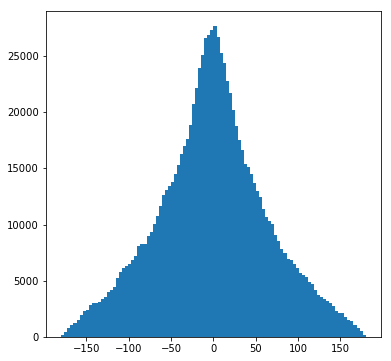

In [9]:
rel_angle = np.abs(df_total['angle_f1']) - np.abs(df_total['angle_f0'])
fix, ax = plt.subplots(figsize=(6,6))
_ = ax.hist(np.rad2deg(rel_angle), bins=100)

14.0795403061 16.3320342857


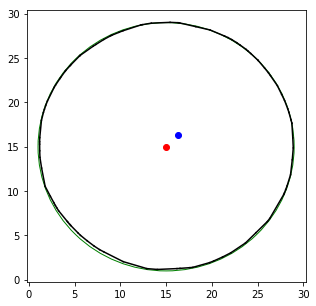

In [10]:
# Estimating the radius/position of the walls
from scipy.spatial import ConvexHull
points =  np.vstack((np.vstack((df.x_f0, df.y_f0)).T, np.vstack((df.x_f1, df.y_f1)).T))
hull = ConvexHull(points)
fig, ax = plt.subplots(figsize=(5,5))
for simplex in hull.simplices:
    ax.plot(points[simplex, 0], points[simplex, 1], 'k-')
cx = np.mean(hull.points[hull.vertices,0])
cy = np.mean(hull.points[hull.vertices,1])
print(cx, cy)
ax.scatter(cy, cy, c='b')
ax.scatter(15, 15, c='red')

circle = plt.Circle((15, 15), 14, color='g', fill=False, clip_on=False)
ax.add_artist(circle)

# Speed and Acceleration

We smooth the speed series with a savgol-filter.
This assumes that all data points are equidistant -> this needs to be fixed!

In [11]:
def smooth(x):    
    # TODO: Use proper values
    degree = 3
    time_window = 18 # change to be 0.36s window
    bandwidth = 4 # change to be 0.08s
    
    x = signal.savgol_filter(x, window_length=49, polyorder=degree, deriv=0) # TODO: Check
    x_deriv = signal.savgol_filter(x, window_length=49, polyorder=degree, deriv=1)
    
    return x, x_deriv

0.00758036007571 0.00398891042878
[ 2.71202288  2.7083393   2.69424715 ...,  0.72009547  0.52926458
  0.31429644]


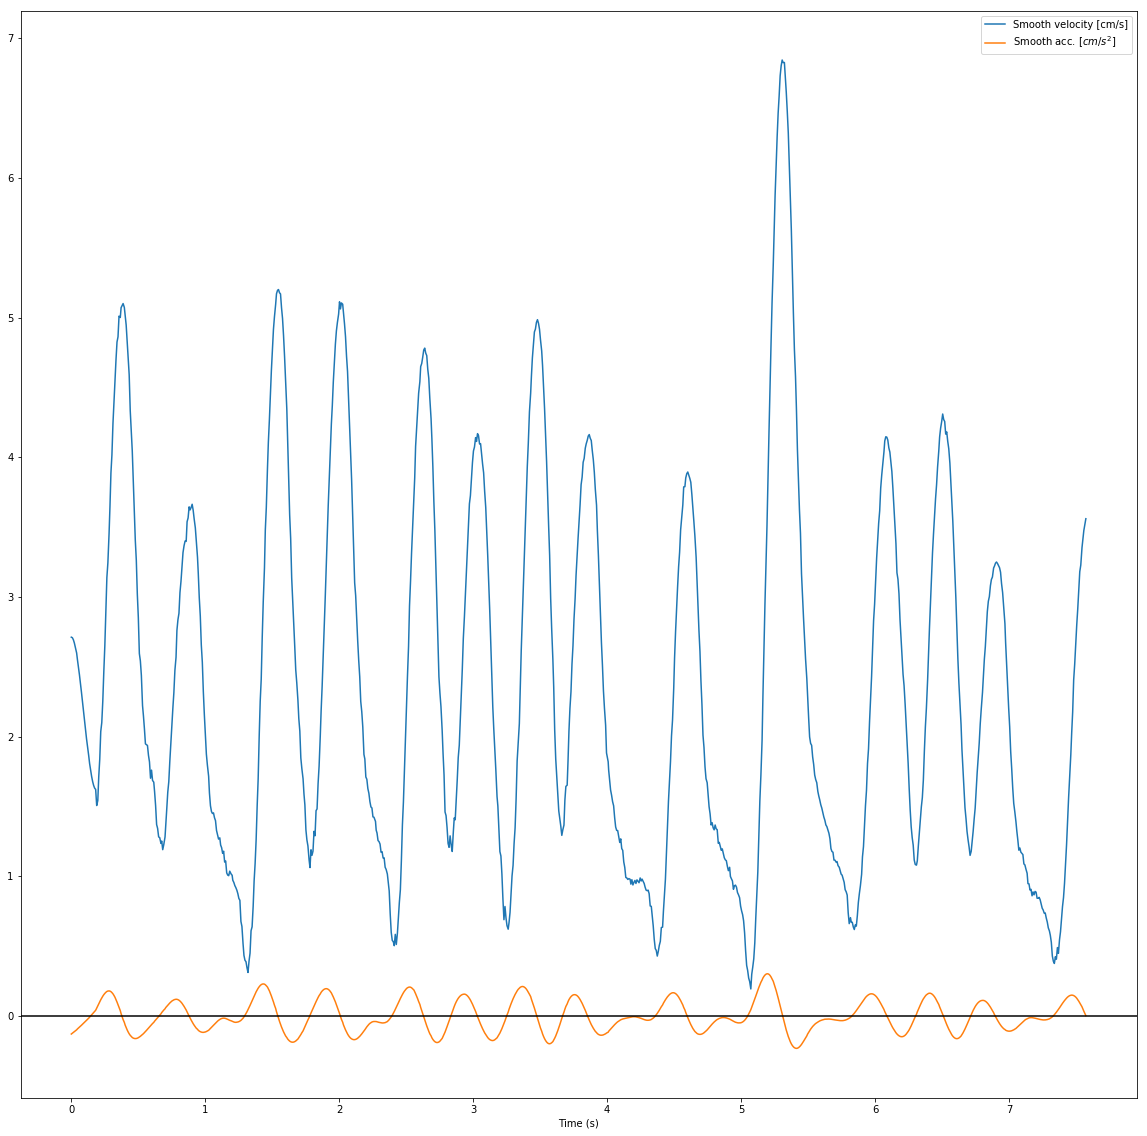

In [12]:
vel0 = df['speed_f0'].values
vel1 = df['speed_f1'].values
vel0_smooth, acc0_smooth = smooth(vel0)
vel1_smooth, acc1_smooth = smooth(vel1)
#acc0_smooth = (np.gradient(vel0_smooth))
time = df['time'].values[:]
time_diff = np.ediff1d(time)
print(np.mean(time_diff), np.std(time_diff))
print(vel0_smooth)

till = 1000
fig, ax = plt.subplots(figsize=(20,20))
ax.plot(time[:till], vel0_smooth[:till], label="Smooth velocity [cm/s]")
ax.plot(time[:till], acc0_smooth[:till], label="Smooth acc. [$cm/s^2$]")
ax.set_xlabel("Time (s)")
ax.set_ylabel("")
ax.legend()
ax.axhline(0, color='black', )

## Select activity

Find out, whether the fish are currently swimming, pausing (for a short time) or stopped (for a long time).

In [13]:
SWIMMING = 0
PAUSING = 1
STOPPING = 2

@jit(nopython=True)
def get_status(vel0, vel1, time, treshold):
    time_window = 4.0 #TODO: Change to 4
    vel_max = np.maximum(vel0, vel1)
    
    time_paused = np.zeros(vel_max.shape)
    
    # Forward pass: Find out how long fish have been pausing
    cur_time_paused = 0
    for i in range(0, len(vel_max)):
        if vel_max[i] >= treshold:
            # Swimming
            cur_time_paused = 0
        else:
            # Pausing or stopping
            if i > 0:
                cur_time_paused += time[i] - time[i - 1]
            else:
                cur_time_paused += time[i]
            #print(cur_time_paused, time[i])
        time_paused[i] = cur_time_paused
        
    # Backwards pass: Set status flags
    status = np.zeros(vel_max.shape)
    is_cur_stopped = False
    for i in range(len(vel_max) - 1, -1, -1):
            if time_paused[i] == 0:
                # Swimming
                is_cur_stopped = False
                status[i] = SWIMMING
            elif is_cur_stopped:
                # Still stopping
                status[i] = STOPPING
            elif time_paused[i] >= treshold:
                # Paused for too long -> Stopping
                is_cur_stopped = True
                status[i] = STOPPING
            else:
                status[i] = PAUSING                    
                    
    return time_paused, status

In [14]:
threshold = 3 # TODO: Find reasonable threshold
#print(time[:100])
td, s = get_status(vel0_smooth[0:], vel1_smooth[0:], time[0:], threshold)

In [15]:
print(s)
print(s.shape, np.mean(s), np.max(s))
for i in range(0,3):
    print(i, len(np.where(s == i)[0]))

[ 0.  0.  0. ...,  0.  0.  0.]
(958966,) 0.496479541506 2.0
0 496894
1 448037
2 14035


In [16]:
td[0:100], s[:100]

(array([ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  0.007644,  0.015138,  0.02269 ,  0.030192,  0.03773 ,
         0.045242,  0.052941,  0.061138,  0.068213,  0.075767,  0.083184,
         0.090853,  0.098356,  0.105939,  0.113593,  0.121479,  0.      ,
         0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.007623,  0.015212,  0.022789,  0.030235,  0.038948,  0.045788,
         0.053157,  0.060632,  0.068216,  0.07575 ,  0.083334,  0.090849,
         0.098581,  0.106121,  0.11370

## Segmentation
Find phases where the fish are accelerating and decelerating.

**TODO**: Need to fuse shorter phases together here for noise reduction.

In [17]:
# Find acc phases
ACCELERATING = 1
GLIDING = -1

@jit(nopython=True)
def segmentation(acc, time):
    phases = (acc > 0.0) * ACCELERATING
    # TODO (maybe): fuse nearby accelerating events
    
    events = []
    
    # (idx_start, idx_end, duration, type)    
    idx_start, idx_end, duration, etype = (0, -1, -1, -1)
    cur_sign = -1 * np.sign(acc[0]) # start with correct event
        
    for i, a in enumerate(acc):
        if np.sign(a) != cur_sign or i == (len(acc) -1):        
            # push old event
            idx_end = i - 1
            duration = time[i - 1] - time[idx_start]
            events.append((idx_start, idx_end, duration, cur_sign))
            
            # start new event
            cur_sign *= -1
            idx_start = i                
        
    return events[1:] # skip first invalid element start = end = 0   

In [18]:
phases = segmentation(acc0_smooth, time)
#phases[0:100], acc0[0:100]
len(phases), len(acc0_smooth), acc0_smooth[0:3]

(32703, 958966, array([-0.12873145, -0.12295835, -0.11707085]))

In [19]:
# Avg. len of a kick
958965/32701 * np.mean(time_diff) * 2

0.44459190850432706

In [20]:
phases[0:30]

[(0, 18, 0.13661800000000002, -1.0),
 (19, 49, 0.22739399999999999, 1.0),
 (50, 86, 0.272807, -1.0),
 (87, 115, 0.2117840000000002, 1.0),
 (116, 170, 0.4093530000000001, -1.0),
 (171, 203, 0.24274000000000018, 1.0),
 (204, 234, 0.22844999999999982, -1.0),
 (235, 264, 0.22043999999999975, 1.0),
 (265, 315, 0.37917000000000023, -1.0),
 (316, 346, 0.22727999999999993, 1.0),
 (347, 373, 0.19703000000000026, -1.0),
 (374, 399, 0.18843000000000032, 1.0),
 (400, 428, 0.21255999999999986, -1.0),
 (429, 458, 0.21989000000000036, 1.0),
 (459, 483, 0.18167000000000044, -1.0),
 (484, 508, 0.18216999999999972, 1.0),
 (509, 574, 0.4927100000000002, -1.0),
 (575, 606, 0.23512000000000022, 1.0),
 (607, 665, 0.43942999999999977, -1.0),
 (666, 700, 0.2577000000000007, 1.0),
 (701, 768, 0.5082500000000003, -1.0),
 (769, 803, 0.2576200000000002, 1.0),
 (804, 831, 0.2047099999999995, -1.0),
 (832, 858, 0.19571000000000005, 1.0),
 (859, 885, 0.19701000000000057, -1.0),
 (886, 909, 0.1737700000000011, 1.0),


In [21]:
for p in phases:
    _, _, d, _ = p
    if d == 0:
        print(p)
time[954404], time[954405]

(60685, 60685, 0.0, 1.0)
(109602, 109602, 0.0, -1.0)
(179210, 179210, 0.0, -1.0)
(183795, 183795, 0.0, 1.0)
(188840, 188840, 0.0, 1.0)
(209048, 209048, 0.0, 1.0)
(237396, 237396, 0.0, 1.0)
(241697, 241697, 0.0, 1.0)
(313617, 313617, 0.0, 1.0)
(343028, 343029, 0.0, 1.0)
(358948, 358948, 0.0, 1.0)
(370183, 370184, 0.0, 1.0)
(388658, 388658, 0.0, -1.0)
(405220, 405220, 0.0, -1.0)
(417108, 417108, 0.0, 1.0)
(430140, 430141, 0.0, -1.0)
(442450, 442450, 0.0, 1.0)
(451692, 451692, 0.0, 1.0)
(456475, 456475, 0.0, 1.0)
(462818, 462818, 0.0, -1.0)
(474130, 474130, 0.0, -1.0)
(506035, 506035, 0.0, -1.0)
(523637, 523637, 0.0, 1.0)
(547275, 547275, 0.0, 1.0)
(557190, 557190, 0.0, 1.0)
(593107, 593107, 0.0, 1.0)
(667255, 667256, 0.0, 1.0)
(668805, 668806, 0.0, -1.0)
(689076, 689077, 0.0, -1.0)
(709730, 709731, 0.0, 1.0)
(758514, 758514, 0.0, 1.0)
(758515, 758515, 0.0, -1.0)
(803510, 803510, 0.0, 1.0)
(849375, 849375, 0.0, 1.0)
(849376, 849376, 0.0, -1.0)
(883298, 883298, 0.0, 1.0)
(892785, 892786, 0

(7234.7299999999996, 7234.7299999999996)

## Angle between fish
We need to find the angle between both fishs.

This part is still a bit dubious. 

In [22]:
# angle_between from https://stackoverflow.com/a/13849249
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2, signed=True):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    if signed:
        return np.arctan2(np.cross(v1_u, v2_u), np.dot(v1_u, v2_u))
    else:
        return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [23]:
def summarise_kick(phases, fish_id, kick_n):
    # A kick consists of one consec. acc. and gliding phase
    p0 = phases[kick_n*2:kick_n*2+2]
    start = p0[0][0]
    end = p0[1][1]
    duration = p0[0][2] + p0[1][2]
    wall_distance = df_total[f'border_distance_f{fish_id}'][start]
    
    # Collect some other summary data about the kick
    try:
        traj_kick = np.zeros(2)
        traj_kick[0] = df_total[f'x_f{fish_id}'][end] - df_total[f'x_f{fish_id}'][start]
        traj_kick[1] = df_total[f'y_f{fish_id}'][end] - df_total[f'y_f{fish_id}'][start]
    except Exception:
        print(f"id={fish_id}, kick_n={kick_n}, start={start}, end={end}, duration={duration}")
        raise
    
    heading = unit_vector(traj_kick)
    kick_len = np.linalg.norm(traj_kick)
    
    #print("Kick_traj. = {}".format(traj_kick))
    #print("Heading = {}, kick_len = {}".format(unit_vector(traj_kick), np.linalg.norm(traj_kick)))
   
    return start, end, duration, heading, kick_len, wall_distance

def summarise_kicks(acc, fish_id):
    phases = segmentation(acc, time)
    # If heading is zero (no current kick) need to estimate traj. differently!
    kicks = []
    
    # Find first acceleration phase
    begin = 0
    for i in range(0, len(phases)):
        if phases[i][-1] == 1:
            begin = i
            break
    print(f"Begin={begin}")
    
    # Calculate kick heading/duration
    for i in range(begin, len(phases)//2):
        kicks.append(summarise_kick(phases, fish_id, i))
        
    # Convert back to frame information (needed for angle calc!)
    avg_heading = np.zeros( (len(acc), 2) ) + 0.000001 # epsilon for stability, remove later
    for k in kicks:
        start, end, _, heading, _, _ = k
        avg_heading[start:end] = heading
        
    return kicks, avg_heading

# TODO: Generalise to other fish combination
def calc_angles(kick, headings_0, headings_1, verbose=False):
    start, end, duration, heading, kick_len, _ = kick
    
    pos_f0 = np.array([df_total['x_f0'][start], df_total['y_f0'][start]]) 
    pos_f1 = np.array([df_total['x_f1'][start], df_total['y_f1'][start]])

    # Traj. vector of both fish
    # We could use the kick direction here for a more stable result
    ## traj_f0 = headings_0[start]
    ## traj_f1 = headings_1[start]
    
    # Use the direct trajectory here. Possible bug here (if kick starts at time 0!)
    traj_f0 = np.zeros(2)
    traj_f1 = np.zeros(2)

    if start != 0:
        traj_f0[0] = df_total['x_f0'][start] - df_total['x_f0'][start - 1]
        traj_f0[1] = df_total['y_f0'][start] - df_total['y_f0'][start - 1]
        traj_f1[0] = df_total['x_f1'][start] - df_total['x_f1'][start - 1]
        traj_f1[1] = df_total['y_f1'][start] - df_total['y_f1'][start - 1]

    # Distance vector
    dist = np.zeros(2)
    dist[0] = df_total['x_f1'][start] - df_total['x_f0'][start]
    dist[1] = df_total['y_f1'][start] - df_total['y_f0'][start]

    # Calculate relevant angles and focal fish
    rad_to_deg = 180/np.pi
    viewing_angle_0t1 = angle_between(traj_f0, dist)
    viewing_angle_1t0 = angle_between(traj_f1, -dist)
    
    if np.abs(viewing_angle_0t1) > np.abs(viewing_angle_1t0):
        geometric_leader = 'f0'
        rel_orientation = angle_between(traj_f0, traj_f1)

    else:
        geometric_leader = 'f1'
        rel_orientation = angle_between(traj_f1, traj_f0)

        
    if rel_orientation != rel_orientation:
        verbose = True
           
    # Collect some other summary data about the kick
    traj_kick = np.zeros(2)
    traj_kick[0] = df_total['x_f0'][end] - df_total['x_f0'][start]
    traj_kick[1] = df_total['y_f0'][end] - df_total['y_f0'][start]
    
    if verbose:
        print("Start = {}, end {}, duration = {}".format(start, end, duration))
        print("Trajectories: f0 = {}, f1 = {}".format(unit_vector(traj_f0), unit_vector(traj_f1)))
        print("x/y: f0 = {}, f1 = {}".format(pos_f0, pos_f1))
        print("Distance = {}, norm = {}, data = {}".format(dist, np.linalg.norm(dist), df_total['neighbor_distance'][start]))

        print("Viewing angles: 0->1 = {:3.2f}°, 1->0 = {:3.2f}°".format(
            viewing_angle_0t1 * rad_to_deg, viewing_angle_1t0 * rad_to_deg))
        print("Geometric leader is {}.".format(geometric_leader))
        print("Relative orientation = {:3.2f}°".format(rel_orientation * rad_to_deg))
        print("Heading = {}, kick_len = {}".format(unit_vector(traj_kick), np.linalg.norm(traj_kick)))
   
    return dist, geometric_leader, viewing_angle_0t1, viewing_angle_1t0, rel_orientation

In [24]:
kicks_0, headings_0 = summarise_kicks(acc0_smooth, 0)
kicks_1, headings_1 = summarise_kicks(acc1_smooth, 1)
print(np.mean(headings_0, axis=0), np.mean(headings_1, axis=0))

kicks_0_df = pd.DataFrame(kicks_0)
kicks_1_df = pd.DataFrame(kicks_1)
columns =  ['start', 'end', 'duration', 'heading', 'kick_len', 'wall_distance']
kicks_0_df.columns = columns
kicks_1_df.columns = columns
kicks_0_df.describe()

Begin=1
Begin=0
[-0.07964165  0.00630583] [-0.0617796   0.02992672]


,start,end,duration,kick_len,wall_distance
count,16350.000000,16350.000000,16350.000000,16350.000000,16350.000000
mean,482818.431498,482876.080000,0.429450,0.698663,19.750958
std,277522.302514,277521.595309,0.142401,0.449059,6.582485
min,50.000000,115.000000,0.010000,0.000714,7.663370
25%,242188.750000,242228.750000,0.330000,0.340791,14.469425
50%,487035.500000,487090.500000,0.400000,0.625351,18.296800
75%,723153.250000,723205.000000,0.500000,1.002710,24.594075
max,958882.000000,958952.000000,1.450000,4.442665,34.968000


In [25]:
for i in range(300,301):
    calc_angles(kicks_0[i], headings_0, headings_1, verbose=True)
    print()

Start = 17701, end 17753, duration = 0.38400000000001455
Trajectories: f0 = [ 0.05410391 -0.99853531], f1 = [-0.98672233  0.16241624]
x/y: f0 = [  5.42863  18.0873 ], f1 = [ 10.5968  12.9329]
Distance = [ 5.16817 -5.1544 ], norm = 7.299165740610361, data = 7.52579
Viewing angles: 0->1 = 41.97°, 1->0 = -35.58°
Geometric leader is f0.
Relative orientation = -102.45°
Heading = [ 0.2135828  -0.97692497], kick_len = 1.0666121113600744



In [26]:
angles_0 = []
angles_1 = []
for kick in kicks_0:
    angles_0.append(calc_angles(kick, headings_0, headings_1, verbose=False))
#for kick in kicks_1:
#    angles_1.append(calc_angles(kick, headings_1, headings_0, verbose=False))

/home/lukas/bin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


Start = 259149, end 259163, duration = 0.09999999999990905
Trajectories: f0 = [ 0.90985216  0.41493258], f1 = [ nan  nan]
x/y: f0 = [ 10.0571  27.1127], f1 = [ 10.8631  27.2268]
Distance = [ 0.806   0.1141], norm = 0.8140361232770932, data = 0.685554
Viewing angles: 0->1 = -16.46°, 1->0 = nan°
Geometric leader is f1.
Relative orientation = nan°
Heading = [ 0.3988283   0.91702562], kick_len = 0.2504837320066924


In [27]:
leader_0 = 0
leader_1 = 0
rel_orientation_l = []
rel_orientation_avg = 0.0
for (dist, geometric_leader, viewing_angle_0t1, viewing_angle_1t0, rel_orientation) in (angles_0 + angles_1):
    if rel_orientation != rel_orientation:
        print(f"nan! dist={dist}, 0->1={viewing_angle_0t1}, 1->0={viewing_angle_1t0}")
        continue
    rel_orientation_avg += rel_orientation
    rel_orientation_l.append(rel_orientation)
    if geometric_leader == 'f0':
        leader_0 += 1
    else:
        leader_1 += 1
rel_orientation_avg = np.rad2deg(rel_orientation_avg/(len(angles_0) + len(angles_1)))
rel_orientation_l = np.array(rel_orientation_l)
print(leader_0, leader_1)
print(f"Rel. orientation {rel_orientation_avg}")

nan! dist=[ 0.806   0.1141], 0->1=-0.2872398651162981, 1->0=nan
7774 8575
Rel. orientation 26.030041063674112


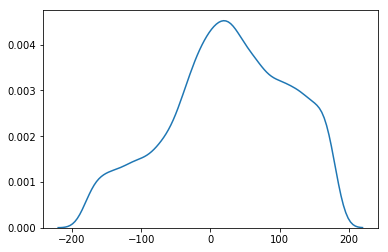

In [28]:
fig, ax = plt.subplots()
#ax.hist(np.rad2deg(rel_orientation_l))
sns.kdeplot(np.rad2deg(rel_orientation_l))

In [31]:
# Calculate the average heading difference between both fish
# Right now I'm using the x-axis as a reference point, shouldn't matter in practice though
hsn = []
for h0, h1 in zip(headings_0, headings_1):
    x_axis = np.array([1.0, 0.0])
    a0 = angle_between(x_axis, h0)
    a1 = angle_between(x_axis, h1)
    hsn.append(a1-a0)
hs = np.array(hsn)
sns.distplot(np.rad2deg(hs[~np.isnan(hs)]))

KeyboardInterrupt: 

In [39]:
# Avg. heading change for fish 0
def plot_avg_heading(ignore_wall=False):
    hsn = []
    threshold_d = np.median(kicks_0_df['wall_distance'])
    for i in range(1, len(kicks_0_df)):
        wall_distance = kicks_0_df['wall_distance'][i]
        if ignore_wall or wall_distance > threshold_d:
            a = angle_between(kicks_0_df['heading'][i], kicks_0_df['heading'][i - 1])
            hsn.append(a)
    hs = np.array(hsn)
    sns.kdeplot(np.rad2deg(hs[~np.isnan(hs)]))
    plt.figure()
    sns.kdeplot(np.abs(np.rad2deg(hs[~np.isnan(hs)])))

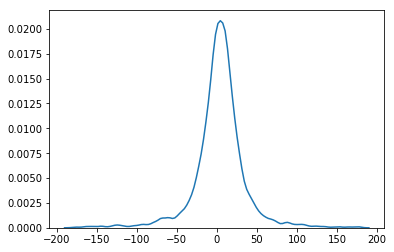

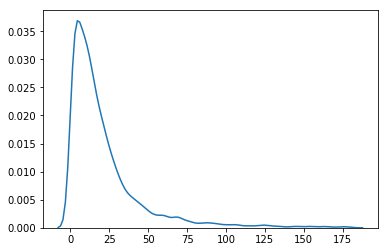

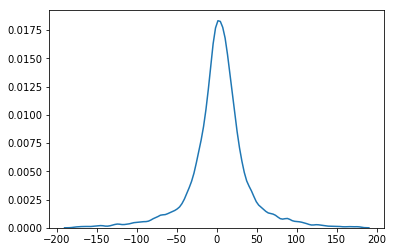

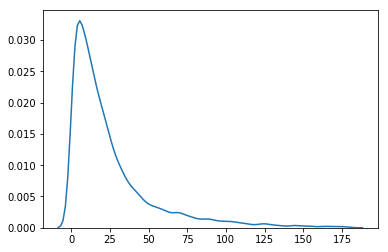

In [40]:
plot_avg_heading(False)
plt.figure()
plot_avg_heading(True)